# Install Dependencies

In [1]:
!nvidia-smi

Sun Apr 24 20:48:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   35C    P5    23W / 320W |   1309MiB / 10240MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import packages

In [2]:
from functools import partial
from datetime import datetime
# from pytz import timezone
from models_vgg16 import model_build, IntervalEval, compute_metrics, model_build_finetune
from utils_vgg16 import parse_example
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
import shutil
import os
os.environ['TF_CUDNN_DETERMINISTIC']='1'

## Parameter setting

In [3]:
# Do not change these params
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = (227, 227, 3)
TEST_SIZE = 0.1 

# Directory and Model name
MODEL_NAME = 'vgg16' #@param ["densenet121", "resnet50", "vgg16"]{type:"raw"}
DATA_DIR = 'tfrecords'
MODEL_DIR = 'models'
TB_DIR = 'tensorboard'

## Parameters for Turning ##
LR = 0.0001 #@param {type:"slider", min:1e-4, max:1e-3, step:1e-4}
NUM_EPOCHS = 6 #@param {type:"slider", min:5, max:15, step:1}
DROP_OUT = 0.2 #@param {type:"slider", min:0, max:0.5, step:0.05}
OHEM_RATE = 0.5 #@param {type:"slider", min:0.1, max:0.8, step:0.1}
DATA_AUG = True #@param {type:"boolean"}
CV_MODE = False #@param {type:"boolean"}
config_num = 15

# set tensorflow global random seed
tf.random.set_seed(1234)

## How does one tfrecord look like?
Data augmentation will include:
* 50% original
* 25% cut out (100*100 zero mask)
* 25% random flip and rotation

In [4]:
eda_dataset = tf.data.TFRecordDataset([os.path.join(DATA_DIR, 'shard100_32.tfrecord')])
eda_dataset = eda_dataset.map(partial(parse_example, data_aug=DATA_AUG, shape=IMAGE_SIZE)).prefetch(AUTOTUNE).batch(BATCH_SIZE)

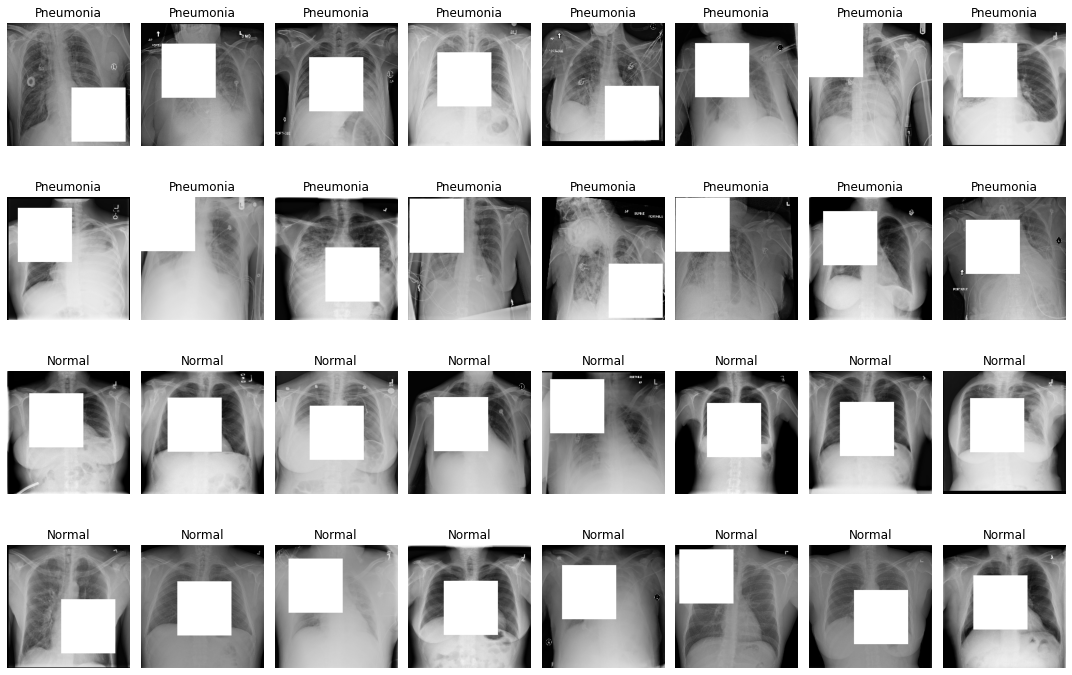

In [5]:
X, y = next(iter(eda_dataset))
f, axes = plt.subplots(nrows=4, ncols=8, figsize=(15, 10))
f.subplots_adjust(wspace=0, hspace=0.05)

for i, (img, label) in enumerate(zip(X, y)):
    r, c = i // 8, i % 8
    axes[r][c].imshow(img)
    axes[r][c].axis('off')
    axes[r][c].set_aspect('equal')
    axes[r][c].set_title('Pneumonia' if label.numpy() else 'Normal')

f.tight_layout()
plt.savefig('./plots/cutout_example.png')
plt.show()

# Training function

In [6]:
def train(run_num):
    # train/test split (DO NOT MODIFY)
    all_tfrecords = [os.path.join(DATA_DIR, x) for x in os.listdir(DATA_DIR)]
    train_val, test = train_test_split(all_tfrecords, test_size=TEST_SIZE, random_state=SEED)
    kf = KFold()

    # test data setup (DO NOT MODIFY)
    test_dataset = tf.data.TFRecordDataset(np.asarray(test))
    test_dataset = test_dataset.map(partial(parse_example, 
                                            data_aug = False,
                                            shape=IMAGE_SIZE)).prefetch(AUTOTUNE).batch(BATCH_SIZE)
    test_samples = sum(int(x.split('.')[0].split('_')[1]) for x in np.asarray(test))

    test_labels = np.zeros((test_samples, ), dtype=np.uint8)
    for i, (_, label) in enumerate(test_dataset):
        test_labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = label

    # Just train on 1 fold if not CV_MODE
    for fold, (tr_idx, val_idx) in enumerate(kf.split(train_val)):

        train_dataset = tf.data.TFRecordDataset(np.asarray(train_val)[tr_idx])
        # call cache before data aug! Otherwise the aug only applied for first epoch
        train_dataset = train_dataset.cache().map(partial(parse_example, 
                                                  data_aug = DATA_AUG,
                                                  shape=IMAGE_SIZE)).shuffle(2048).prefetch(AUTOTUNE).batch(BATCH_SIZE).repeat(NUM_EPOCHS)
        train_samples = sum(int(x.split('.')[0].split('_')[1]) for x in np.asarray(train_val)[tr_idx])

        valid_dataset = tf.data.TFRecordDataset(np.asarray(train_val)[val_idx])
        valid_dataset = valid_dataset.map(partial(parse_example, 
                                                  data_aug = False,
                                                  shape=IMAGE_SIZE)).prefetch(AUTOTUNE).batch(BATCH_SIZE)
        valid_samples = sum(int(x.split('.')[0].split('_')[1]) for x in np.asarray(train_val)[val_idx])

        valid_labels = np.zeros((valid_samples, ), dtype=np.uint8)
        for i, (_, label) in enumerate(valid_dataset):
            valid_labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = label

        # Interval evaluation callback
        saved_model_name = os.path.join(MODEL_DIR, f'{MODEL_NAME}_fold{fold}')
       
        ieval = IntervalEval(
            saved_model_name, 
            valid_dataset, 
            # valid_samples,
            valid_labels,
            test_dataset,
            # test_samples,
            test_labels,
            True
        )

        # csvlogger callback
        csv_logger = keras.callbacks.CSVLogger('./logs/train_log.csv', append=False)

        # Tensorboard callback
        tmp_tb_dir = os.path.join(TB_DIR, 'tmp')
        if 'tmp' in os.listdir(TB_DIR): shutil.rmtree(tmp_tb_dir)
        os.mkdir(tmp_tb_dir)
        tbCallBack = tf.keras.callbacks.TensorBoard(log_dir=tmp_tb_dir,
                                                    histogram_freq=0, 
                                                    write_graph=True, 
                                                    write_images=True)
        
        # Initiate model
        model = model_build_finetune(train_samples,
                            drop_out=DROP_OUT,
                            lr=LR, 
                            ohem_rate=OHEM_RATE, 
                            num_epochs=NUM_EPOCHS, 
                            model_name=MODEL_NAME)
        steps_per_epoch = int(np.ceil(train_samples / BATCH_SIZE))

        # Model training
        model.fit(train_dataset,
                  steps_per_epoch=steps_per_epoch,
                  validation_data = valid_dataset,
                  epochs= NUM_EPOCHS,
                  callbacks=[
                    ieval, 
                    tbCallBack, 
                    csv_logger
                    ],
                  verbose=1,
                  use_multiprocessing=True
                )
        
        # Rename the tensorboard and training log folder based on model performance (separate from other training)
        s1 = ieval.f1_name.split('\\')[1].strip('.h5')
        os.rename(tmp_tb_dir, 
                  os.path.join(TB_DIR, f"{s1}_run{run_num}_config{config_num}"))
        os.rename('./logs/train_log.csv', 
                  f"./logs/train_log_{s1}_run{run_num}_config{config_num}.csv")
        if not CV_MODE: break

    return model, ieval

In [7]:
loss_hist = []
val_loss_hist = []
BestF1Train_hist = []
BestEpoch_hist = []
BestF1Test_hist = []
for i in range(5):
    model, model_cbk = train(i)
    loss_hist.append(model_cbk.loss)
    val_loss_hist.append(model_cbk.val_loss)
    BestF1Train_hist.append(model_cbk.score_max[-1])
    BestEpoch_hist.append(model_cbk.best_epoch_f1+1)
    BestF1Test_hist.append(model_cbk.test_score[-1])

Epoch 1/6
145/145 [==============================] - ETA: 0s - loss: 1.4340
AUC: 0.76938 Precision: 0.76136 Recall: 0.58059 F1:  0.65880
F1 improved from -1.00000 to 0.65880
145/145 [==============================] - 30s 170ms/step - loss: 1.4340 - val_loss: 0.5998
Epoch 2/6
145/145 [==============================] - ETA: 0s - loss: 0.5991
AUC: 0.80992 Precision: 0.76772 Recall: 0.67591 F1:  0.71889
F1 improved from 0.65880 to 0.71889
145/145 [==============================] - 22s 151ms/step - loss: 0.5991 - val_loss: 0.5461
Epoch 3/6
145/145 [==============================] - ETA: 0s - loss: 0.5432
AUC: 0.81890 Precision: 0.77490 Recall: 0.67418 F1:  0.72104
F1 improved from 0.71889 to 0.72104
145/145 [==============================] - 22s 153ms/step - loss: 0.5432 - val_loss: 0.5361
Epoch 4/6
144/145 [============================>.] - ETA: 0s - loss: 0.5109
AUC: 0.82352 Precision: 0.70906 Recall: 0.84055 F1:  0.76923
F1 improved from 0.72104 to 0.76923
145/145 [======================

144/145 [============================>.] - ETA: 0s - loss: 1.5669
AUC: 0.74846 Precision: 0.62745 Recall: 0.83189 F1:  0.71535
F1 improved from -1.00000 to 0.71535
145/145 [==============================] - 24s 157ms/step - loss: 1.5654 - val_loss: 0.6214
Epoch 2/6
144/145 [============================>.] - ETA: 0s - loss: 0.6219
AUC: 0.77410 Precision: 0.65270 Recall: 0.83709 F1:  0.73349
F1 improved from 0.71535 to 0.73349
145/145 [==============================] - 23s 154ms/step - loss: 0.6216 - val_loss: 0.5893
Epoch 3/6
144/145 [============================>.] - ETA: 0s - loss: 0.5577
AUC: 0.80291 Precision: 0.76471 Recall: 0.69844 F1:  0.73007
145/145 [==============================] - 23s 159ms/step - loss: 0.5578 - val_loss: 0.5479
Epoch 4/6
145/145 [==============================] - ETA: 0s - loss: 0.5246
AUC: 0.81335 Precision: 0.77055 Recall: 0.69844 F1:  0.73273
145/145 [==============================] - 25s 171ms/step - loss: 0.5246 - val_loss: 0.5355
Epoch 5/6
145/145 [==

In [9]:
print(BestF1Train_hist)
print(BestF1Test_hist)
print(BestEpoch_hist)

[0.7883461868037703, 0.7917981072555206, 0.7928802588996764, 0.7592425608656447, 0.7793991416309013]
[0.7913446676970634, 0.7756410256410255, 0.768503937007874, 0.763458401305057, 0.7608346709470305]
[4, 1, 3, 6, 1]


In [10]:
loss_hist_np = np.asarray(loss_hist)
val_loss_hist_np = np.asarray(val_loss_hist)
BestF1Train_hist_np = np.asarray(BestF1Train_hist)
BestF1Test_hist_np = np.asarray(BestF1Test_hist)
print(loss_hist_np)
print(val_loss_hist_np)
loss_hist_mean = np.mean(loss_hist_np, axis=0)
val_loss_hist_mean = np.mean(val_loss_hist_np, axis=0)
BestF1Train_hist_mean = np.mean(BestF1Train_hist_np)
BestF1Test_hist_mean = np.mean(BestF1Test_hist_np)
print(loss_hist_mean)
print(val_loss_hist_mean)
print(f"Mean of BestF1ValidationScore {NUM_EPOCHS}epochs over 5 runs: {BestF1Train_hist_mean}")
print(f"Mean of BestF1TestScore {NUM_EPOCHS}epochs over 5 runs: {BestF1Test_hist_mean}")

[[0.57290518 0.51012987 0.46961659 0.43385381 0.40024945 0.36111814]
 [0.60196698 0.55613202 0.5284009  0.51151085 0.48172784 0.46475706]
 [0.6087473  0.53932488 0.50032949 0.47398692 0.44606116 0.41438466]
 [0.60030657 0.54604447 0.52907497 0.49127924 0.46508941 0.44686866]
 [0.65814972 0.57068217 0.53859228 0.51520944 0.49671093 0.48424855]]
[[0.54178685 0.48520657 0.46369281 0.45577195 0.46111742 0.46773288]
 [0.51754028 0.51686072 0.52998173 0.51018023 0.48296145 0.48732466]
 [0.53066522 0.5014438  0.48492876 0.50834352 0.46893659 0.46744889]
 [0.55099463 0.58973074 0.4860132  0.49684545 0.50297749 0.48215985]
 [0.50858581 0.50574696 0.49448165 0.47524878 0.48334375 0.47433469]]
[0.60841515 0.54446268 0.51320285 0.48516805 0.45796776 0.43427541]
[0.52991456 0.51979776 0.49181963 0.48927799 0.47986734 0.47580019]
Mean of BestF1ValidationScore 6epochs over 5 runs: 0.7823332510911027
Mean of BestF1TestScore 6epochs over 5 runs: 0.77195654051961


In [11]:
config_num

1

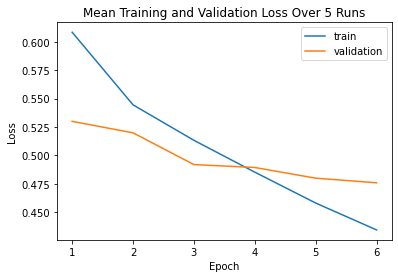

In [12]:
plt.plot(range(1, NUM_EPOCHS+1), loss_hist_mean, label='train')
plt.plot(range(1, NUM_EPOCHS+1), val_loss_hist_mean, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Mean Training and Validation Loss Over 5 Runs' )
plt.legend()
plt.savefig(f"./plots/6Epochs_AverageLoss_Config{config_num}.png")
plt.show()

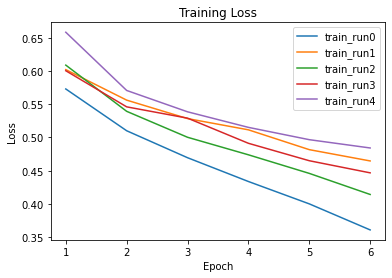

In [13]:
for i in range(5):
    plt.plot(range(1, NUM_EPOCHS+1), loss_hist[i], label=f"train_run{i}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig(f"./plots/6Epochs_TrainLoss_5Runs_Config{config_num}.png")
plt.show()

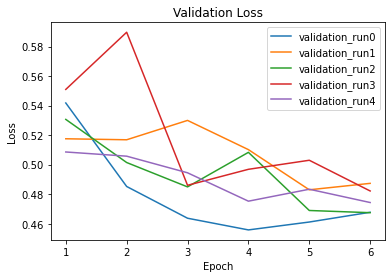

In [14]:
for i in range(5):
    plt.plot(range(1, NUM_EPOCHS+1), val_loss_hist[i], label=f"validation_run{i}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.savefig(f"./plots/6Epochs_ValidationLoss_5Runs_Config{config_num}.png")
plt.show()

In [15]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [16]:
model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
model.compile(
    keras.optimizers.Adam(learning_rate=keras.experimental.CosineDecay(0.0001, 870, alpha=0)),
    loss='binary_crossentropy',
)

In [18]:
def train_finetune(model_in):
    # train/test split (DO NOT MODIFY)
    all_tfrecords = [os.path.join(DATA_DIR, x) for x in os.listdir(DATA_DIR)]
    train_val, test = train_test_split(all_tfrecords, test_size=TEST_SIZE, random_state=SEED)
    kf = KFold()

    # test data setup (DO NOT MODIFY)
    test_dataset = tf.data.TFRecordDataset(np.asarray(test))
    test_dataset = test_dataset.map(partial(parse_example, 
                                            data_aug = False,
                                            shape=IMAGE_SIZE)).prefetch(AUTOTUNE).batch(BATCH_SIZE)
    test_samples = sum(int(x.split('.')[0].split('_')[1]) for x in np.asarray(test))

    test_labels = np.zeros((test_samples, ), dtype=np.uint8)
    for i, (_, label) in enumerate(test_dataset):
        test_labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = label

    # Just train on 1 fold if not CV_MODE
    for fold, (tr_idx, val_idx) in enumerate(kf.split(train_val)):

        train_dataset = tf.data.TFRecordDataset(np.asarray(train_val)[tr_idx])
        # call cache before data aug! Otherwise the aug only applied for first epoch
        train_dataset = train_dataset.cache().map(partial(parse_example, 
                                                  data_aug = DATA_AUG,
                                                  shape=IMAGE_SIZE)).shuffle(2048).prefetch(AUTOTUNE).batch(BATCH_SIZE).repeat(NUM_EPOCHS)
        train_samples = sum(int(x.split('.')[0].split('_')[1]) for x in np.asarray(train_val)[tr_idx])

        valid_dataset = tf.data.TFRecordDataset(np.asarray(train_val)[val_idx])
        valid_dataset = valid_dataset.map(partial(parse_example, 
                                                  data_aug = False,
                                                  shape=IMAGE_SIZE)).prefetch(AUTOTUNE).batch(BATCH_SIZE)
        valid_samples = sum(int(x.split('.')[0].split('_')[1]) for x in np.asarray(train_val)[val_idx])

        valid_labels = np.zeros((valid_samples, ), dtype=np.uint8)
        for i, (_, label) in enumerate(valid_dataset):
            valid_labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = label

        # Interval evaluation callback
        saved_model_name = os.path.join(MODEL_DIR, f'{MODEL_NAME}_fold{fold}')
       
        ieval = IntervalEval(
            saved_model_name, 
            valid_dataset, 
            # valid_samples,
            valid_labels,
            test_dataset,
            # test_samples,
            test_labels,
            True
        )

        # csvlogger callback
        csv_logger = keras.callbacks.CSVLogger('./logs/train_log.csv', append=False)

        # Tensorboard callback
        tmp_tb_dir = os.path.join(TB_DIR, 'tmp')
        if 'tmp' in os.listdir(TB_DIR): shutil.rmtree(tmp_tb_dir)
        os.mkdir(tmp_tb_dir)
        tbCallBack = tf.keras.callbacks.TensorBoard(log_dir=tmp_tb_dir,
                                                    histogram_freq=0, 
                                                    write_graph=True, 
                                                    write_images=True)
        
        steps_per_epoch = int(np.ceil(train_samples / BATCH_SIZE))

        model = model_in
        # Model training
        model.fit(train_dataset,
                  steps_per_epoch=steps_per_epoch,
                  validation_data = valid_dataset,
                  epochs= NUM_EPOCHS,
                  callbacks=[
                    ieval, 
                    tbCallBack, 
                    csv_logger
                    ],
                  verbose=1,
                  use_multiprocessing=True
                )
        
        # Rename the tensorboard and training log folder based on model performance (separate from other training)
        os.rename(tmp_tb_dir, 
                  os.path.join(TB_DIR, ieval.f1_name.split('\\')[1].strip(".h5")))
        s1 = ieval.f1_name.split('\\')[1].strip('.h5')
        os.rename('./logs/train_log.csv', 
                  f"./logs/train_log_{s1}.csv")
        if not CV_MODE: break

    return model, ieval

In [19]:
for layer in model.layers:
    print(layer.name, layer)
print(len(model.layers))
print(model.layers[21].weights)

input_1 <keras.engine.input_layer.InputLayer object at 0x000001C5FCF8FE50>
block1_conv1 <keras.layers.convolutional.Conv2D object at 0x000001C5CA2B3C70>
block1_conv2 <keras.layers.convolutional.Conv2D object at 0x000001C5CA2BA4C0>
block1_pool <keras.layers.pooling.MaxPooling2D object at 0x000001C5CA2B3A90>
block2_conv1 <keras.layers.convolutional.Conv2D object at 0x000001C5CA2FE7C0>
block2_conv2 <keras.layers.convolutional.Conv2D object at 0x000001C5CA2F19D0>
block2_pool <keras.layers.pooling.MaxPooling2D object at 0x000001C5CA2F51C0>
block3_conv1 <keras.layers.convolutional.Conv2D object at 0x000001C5CA316A90>
block3_conv2 <keras.layers.convolutional.Conv2D object at 0x000001C5CA31B250>
block3_conv3 <keras.layers.convolutional.Conv2D object at 0x000001C5CA327970>
block3_pool <keras.layers.pooling.MaxPooling2D object at 0x000001C5CA31B670>
block4_conv1 <keras.layers.convolutional.Conv2D object at 0x000001C5CA2BA550>
block4_conv2 <keras.layers.convolutional.Conv2D object at 0x000001C5CA

In [10]:
print(model.layers[1].weights)

[<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[ 4.28858608e-01,  1.15886837e-01,  3.48749198e-02, ...,
          -1.28608957e-01, -5.30087799e-02,  8.32147524e-03],
         [ 5.49767196e-01,  1.94904674e-02,  9.96932387e-02, ...,
          -8.11878666e-02, -5.08001707e-02,  3.82384285e-02],
         [ 4.79403436e-01, -1.74083740e-01,  3.84196751e-02, ...,
          -1.23502925e-01, -4.99604195e-02,  3.56406532e-02]],

        [[ 3.72744411e-01,  1.60739690e-01,  2.18999619e-03, ...,
          -1.44662037e-01, -2.35176042e-01, -6.27075881e-02],
         [ 4.39351946e-01,  4.60182428e-02,  5.18633164e-02, ...,
          -9.53048468e-02, -2.96071470e-01, -7.01075792e-02],
         [ 4.07824814e-01, -1.71697989e-01, -4.48160153e-03, ...,
          -1.18815534e-01, -2.76326120e-01, -3.87514792e-02]],

        [[-6.22158945e-02,  1.34344622e-01, -1.15764186e-01, ...,
          -1.36379182e-01, -3.77745837e-01, -3.00689906e-01],
         [-8.2242876

In [40]:
model.summary()
model.optimizer.get_config()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

{'name': 'Adam',
 'learning_rate': {'class_name': 'CosineDecay',
  'config': {'initial_learning_rate': 0.0002,
   'decay_steps': 870,
   'alpha': 0,
   'name': None}},
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [22]:
model, model_cbk = train_finetune(model)

Epoch 1/6
145/145 [==============================] - ETA: 0s - loss: 0.7189
AUC: 0.65766 Precision: 0.00000 Recall: 0.00000 F1:  0.00000
F1 improved from -1.00000 to 0.00000
145/145 [==============================] - 26s 163ms/step - loss: 0.7189 - val_loss: 0.6908
Epoch 2/6


C:\Users\chuan\.conda\envs\cs7643-project\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


145/145 [==============================] - ETA: 0s - loss: 0.6477
AUC: 0.77966 Precision: 0.71661 Recall: 0.76256 F1:  0.73887
F1 improved from 0.00000 to 0.73887
145/145 [==============================] - 23s 157ms/step - loss: 0.6477 - val_loss: 0.5842
Epoch 3/6
145/145 [==============================] - ETA: 0s - loss: 0.5696
AUC: 0.81385 Precision: 0.75680 Recall: 0.77123 F1:  0.76395
F1 improved from 0.73887 to 0.76395
145/145 [==============================] - 23s 158ms/step - loss: 0.5696 - val_loss: 0.5374
Epoch 4/6
145/145 [==============================] - ETA: 0s - loss: 0.5277
AUC: 0.84166 Precision: 0.73636 Recall: 0.84229 F1:  0.78577
F1 improved from 0.76395 to 0.78577
145/145 [==============================] - 23s 159ms/step - loss: 0.5277 - val_loss: 0.5088
Epoch 5/6
145/145 [==============================] - ETA: 0s - loss: 0.4996
AUC: 0.84366 Precision: 0.80632 Recall: 0.66378 F1:  0.72814
145/145 [==============================] - 23s 159ms/step - loss: 0.4996 - val

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [26]:
print(model.layers[1].weights)

[<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[ 4.28325981e-01,  1.15229845e-01,  3.41137126e-02, ...,
          -1.28928348e-01, -5.29659241e-02,  7.79946893e-03],
         [ 5.49234211e-01,  1.88335441e-02,  9.89318937e-02, ...,
          -8.15073326e-02, -5.07573113e-02,  3.77164185e-02],
         [ 4.78870809e-01, -1.74740538e-01,  3.76584679e-02, ...,
          -1.23822480e-01, -4.99175638e-02,  3.51186432e-02]],

        [[ 3.72236609e-01,  1.60081133e-01,  1.63665041e-03, ...,
          -1.44937143e-01, -2.35069141e-01, -6.29869550e-02],
         [ 4.38844144e-01,  4.53600325e-02,  5.13099879e-02, ...,
          -9.55796912e-02, -2.95964301e-01, -7.03869835e-02],
         [ 4.07317013e-01, -1.72356561e-01, -5.03494684e-03, ...,
          -1.19090378e-01, -2.76218951e-01, -3.90309133e-02]],

        [[-6.27077818e-02,  1.33723006e-01, -1.15977667e-01, ...,
          -1.36739016e-01, -3.77572000e-01, -3.00658733e-01],
         [-8.2734704

In [27]:
print(model.layers[21].weights)

[<tf.Variable 'pneumonia/kernel:0' shape=(512, 1) dtype=float32, numpy=
array([[-7.11697992e-03],
       [ 8.48978013e-02],
       [-3.61470394e-02],
       [-2.17191149e-02],
       [ 1.04404971e-01],
       [ 4.96602058e-02],
       [ 3.22535983e-03],
       [ 5.12578487e-02],
       [ 1.03096873e-01],
       [-5.22690043e-02],
       [ 1.87607054e-02],
       [ 4.16520610e-02],
       [ 9.72477123e-02],
       [-1.57486480e-02],
       [ 7.40633681e-02],
       [-2.42593661e-02],
       [-1.02134220e-01],
       [ 2.35465486e-02],
       [ 8.72924700e-02],
       [ 6.24069646e-02],
       [-9.44988504e-02],
       [ 1.61573365e-02],
       [ 9.33594704e-02],
       [-7.40306973e-02],
       [ 9.12626162e-02],
       [-5.14697433e-02],
       [ 7.39869475e-02],
       [ 4.82632173e-03],
       [-4.12875228e-02],
       [-1.03536479e-01],
       [ 7.13294670e-02],
       [-4.86458279e-02],
       [ 7.48077482e-02],
       [-2.46203020e-02],
       [ 4.53738831e-02],
       [ 5.5446621

# Don't want to keep the model weights and tensorboard files?

In [10]:
shutil.rmtree(MODEL_DIR)
os.mkdir(MODEL_DIR)

In [21]:
s1 = model_cbk.f1_name.split('\\')[1].strip('.h5')
os.remove(f"./logs/train_log_{s1}.csv")
shutil.rmtree(os.path.join(TB_DIR, model_cbk.f1_name.split('\\')[1].strip('.h5')))

# Log the model training parameters

In [22]:
model_cbk.score_max

[0.8603288080107838, 0.7546875, 0.8370883882149047, 0.7937551355792933]

In [23]:
model_cbk.test_preds

array([[7.27194548e-01],
       [9.06905174e-01],
       [9.57961440e-01],
       [8.56409073e-01],
       [7.11931646e-01],
       [8.87408614e-01],
       [9.88388598e-01],
       [3.82540762e-01],
       [1.78088576e-01],
       [9.51373160e-01],
       [8.13696742e-01],
       [8.52487028e-01],
       [9.64917615e-02],
       [6.53228462e-01],
       [9.91253197e-01],
       [6.09864295e-01],
       [3.88174474e-01],
       [5.68669379e-01],
       [6.58590794e-02],
       [6.25346899e-01],
       [5.90740927e-02],
       [4.91092727e-03],
       [5.53278506e-01],
       [7.56546974e-01],
       [9.84513294e-03],
       [6.35941982e-01],
       [9.88327682e-01],
       [1.81815833e-01],
       [2.82922149e-01],
       [6.81578696e-01],
       [4.93562043e-01],
       [1.58742163e-02],
       [8.50724638e-01],
       [9.81524169e-01],
       [9.94640172e-01],
       [1.02375954e-01],
       [9.17396963e-01],
       [8.75779390e-01],
       [9.97909725e-01],
       [5.08454263e-01],


In [24]:
model_cbk.test_score

(0.8416374610591899,
 0.7725856697819314,
 0.7725856697819314,
 0.7725856697819314)

In [11]:
val_auc, val_prc, val_rec, val_f1 = model_cbk.score_max
test_auc, test_prc, test_rec, test_f1 =  model_cbk.test_score

with open('./logs/training_log.txt', 'a') as f:
    f.write("-"*50 + '\n')
    s1 = model_cbk.f1_name.split('\\')[1]
    f.write(f"{s1}\n")
    f.write(f"Validation AUC: {val_auc:.5f} Precision: {val_prc:.5f} Recall: {val_rec:.5f} F1: {val_f1: .5f}\n")
    f.write(f"Test AUC: {test_auc:.5f} Precision: {test_prc:.5f} Recall: {test_rec:.5f} F1: {test_f1: .5f}\n")
#     f.write(f"Tune new last layer with LR = 0.01, then fine tuning with LR = {0.0001}\n")
    f.write(f"Fine tune without last layer pre-tune with LR = {LR}\n")
    f.write(f"Epochs = {NUM_EPOCHS}\n")
    f.write(f"Drop out = {DROP_OUT}\n")
#     f.write(f"Pool2_relu + Pool3_relu Global Average Pooling\n")
    f.write(f"Global Average Pooling\n")
    # f.write(f"GeM Pooling\n")
    # f.write(f"OHEM Loss with rate {OHEM_RATE}\n")
    f.write(f"Data augmentation on whole batch optimized\n")
    f.write(" "*2+"- 25% random flip and rotation\n")
    f.write(" "*2+"- 50% cutout of 100*100\n")
    f.write(" "*2+"- 25% original\n")
#     f.write(f"No Data Augmentation\n")

# Training and validation loss curve

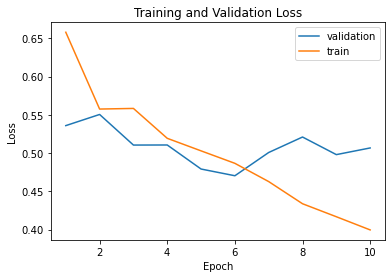

In [12]:
# df_train_hx = pd.read_csv(f"./logs/train_log_{model_cbk.f1_name.split('/')[1].strip('.h5')}.csv")
df_train_hx = pd.read_csv("./logs/train_log_vgg16_fold0_val78040_test75621_FineTuningWoLastLayerPreTuning.csv")

plt.plot(range(1, NUM_EPOCHS+1), df_train_hx['val_loss'], label='validation')
plt.plot(range(1, NUM_EPOCHS+1), df_train_hx['loss'], label='train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('./plots/train_log_vgg16_fold0_val78040_test75621_FineTuningWoLastLayerPreTuning.png')
plt.show()

# Update `.gitignore`

In [ ]:
%%writefile .gitignore
/.idea
/__pycache__
/model
/models
/output
/data
/tfrecords
/proposal
/model_weights
/tensorboard
/.ipynb_checkpoints
#/proposal
*.zip
meta_data.csv
stage_2_train_labels.csv
scratch.py
#models.py
training.py
github_token.txt
kaggle.json
# Training.ipynb
# training_log.txt

Overwriting .gitignore


# Scratch space

In [ ]:
random_num = 0.8
if random_num < 0.25:
    print('<0.25')
elif random_num < 0.5:
    print('<0.5')

In [ ]:
import tensorflow_addons as tfa
X_masked = tfa.image.cutout(X, mask_size = (30, 30))


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    ])
X_aug = data_augmentation(X)

In [ ]:
X_aug.shape

TensorShape([32, 227, 227, 3])